In [ ]:
import pandas as pd
import mysql.connector
import os
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
from time import sleep


/Users/riyashivolkar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:


# Connect to MySQL
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='shivolkar',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing CSV files
folder_path = '/Users/riyashivolkar/Downloads/data'

# List of CSV files and their table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('order_items.csv', 'order_items'),
    ('payments.csv', 'payments')
]

# Function to get SQL data type from Pandas dtype
def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

# Process each CSV file
for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)

    # Load CSV into DataFrame
    df = pd.read_csv(file_path)
    print(f"\n🔹 Processing {csv_file}")

    # Standardize column names (remove spaces, special characters, and lowercase them)
    df.columns = [col.strip().replace(' ', '_').replace('-', '_').replace('.', '_').lower() for col in df.columns]

    # Rename product_category -> product_category_name
    if table_name == 'products':
        df.rename(columns={'product_category': 'product_category_name'}, inplace=True)



    # 🚀 **Handling Missing Values**
    if table_name == 'orders':
        df = df.assign(order_approved_at=df['order_approved_at'].fillna(df['order_purchase_timestamp']))
        df = df.assign(order_delivered_carrier_date=df['order_delivered_carrier_date'].fillna(df['order_estimated_delivery_date']))
        df = df.assign(order_delivered_customer_date=df['order_delivered_customer_date'].fillna(df['order_estimated_delivery_date']))

    elif table_name == 'products':
        df = df.assign(product_category_name=df['product_category_name'].fillna('unknown'))
        df = df.assign(product_name_length=df['product_name_length'].fillna(df['product_name_length'].median()))
        df = df.assign(product_description_length=df['product_description_length'].fillna(df['product_description_length'].median()))
        df = df.assign(product_photos_qty=df['product_photos_qty'].fillna(df['product_photos_qty'].median()))
        df = df.assign(product_weight_g=df['product_weight_g'].fillna(df['product_weight_g'].median()))
        df = df.assign(product_length_cm=df['product_length_cm'].fillna(df['product_length_cm'].median()))
        df = df.assign(product_height_cm=df['product_height_cm'].fillna(df['product_height_cm'].median()))
        df = df.assign(product_width_cm=df['product_width_cm'].fillna(df['product_width_cm'].median()))

    # Convert NaN to None for SQL compatibility
    df = df.where(pd.notnull(df), None)

    # Show Missing Values After Cleaning
    print(df.isnull().sum())

    # Create Table Query (Drop old table to fix column name issue)
    cursor.execute(f"DROP TABLE IF EXISTS `{table_name}`")

    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert Clean Data into MySQL
    for _, row in df.iterrows():
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit transaction
    conn.commit()
    print(f"✅ Successfully cleaned and loaded {csv_file} into {table_name}\n")

# Close connection
conn.close()
print("\n🎉 Data cleaning & insertion completed!")



🔹 Processing customers.csv
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
✅ Successfully cleaned and loaded customers.csv into customers


🔹 Processing orders.csv
order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64
✅ Successfully cleaned and loaded orders.csv into orders


🔹 Processing sellers.csv
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64
✅ Successfully cleaned and loaded sellers.csv into sellers


🔹 Processing products.csv
product_id                    0
product_category_name         0
product_name_length           0
product_description_length    0
pro

In [ ]:


db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='shivolkar',
    database='ecommerce'
)
cur=db.cursor()

In [ ]:


folder_path = '/Users/riyashivolkar/Downloads/data'

csv_files = {
    'customers': 'customers.csv',
    'orders': 'orders.csv',
    'sellers': 'sellers.csv',
    'products': 'products.csv',
    'geolocation': 'geolocation.csv',
    'order_items': 'order_items.csv',
    'payments': 'payments.csv'
}

dataframes = {}

for table, file in csv_files.items():
    df = pd.read_csv(os.path.join(folder_path, file))
    df.columns = [col.strip().replace(' ', '_').replace('-', '_').replace('.', '_').lower() for col in df.columns]
    dataframes[table] = df




# 1. List all unique cities where customers are located.


In [ ]:
unique_cities = dataframes['customers']['customer_city'].dropna().unique()
df_unique_cities = pd.DataFrame(unique_cities, columns=['Customer City'])

df_unique_cities


,Customer City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# 2. Count the number of orders placed in 2017.


In [ ]:
dataframes['orders']['order_purchase_timestamp'] = pd.to_datetime(dataframes['orders']['order_purchase_timestamp'], errors='coerce')

orders_2017 = dataframes['orders'][dataframes['orders']['order_purchase_timestamp'].dt.year == 2017]

total_orders_2017 = len(orders_2017)

print(f"Total orders placed in 2017: {total_orders_2017}")


Total orders placed in 2017: 45101


# 3. Find the total sales per category.


In [ ]:
merged_df = dataframes['order_items'].merge(dataframes['products'], on='product_id').merge(dataframes['payments'], on='order_id')
df_sales = merged_df.groupby('product_category', as_index=False)['payment_value'].sum()
df_sales['payment_value'] = df_sales['payment_value'].round(2)
df_sales.columns = ['Category', 'Sales']
df_sales

,Category,Sales
0,Agro Industria e Comercio,118730.61
1,Art,30992.93
2,Arts and Crafts,2326.17
3,Bags Accessories,187151.29
4,Blu Ray DVDs,7935.28
...,...,...
68,sport leisure,1392127.56
69,stationary store,317440.07
70,technical books,24915.44
71,telephony,486882.05


/var/folders/nw/bzm5v5js71dcfp1ywhh2mgp40000gn/T/ipykernel_48923/4221799825.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Sales', y='Category', data=df_sales, palette='viridis')


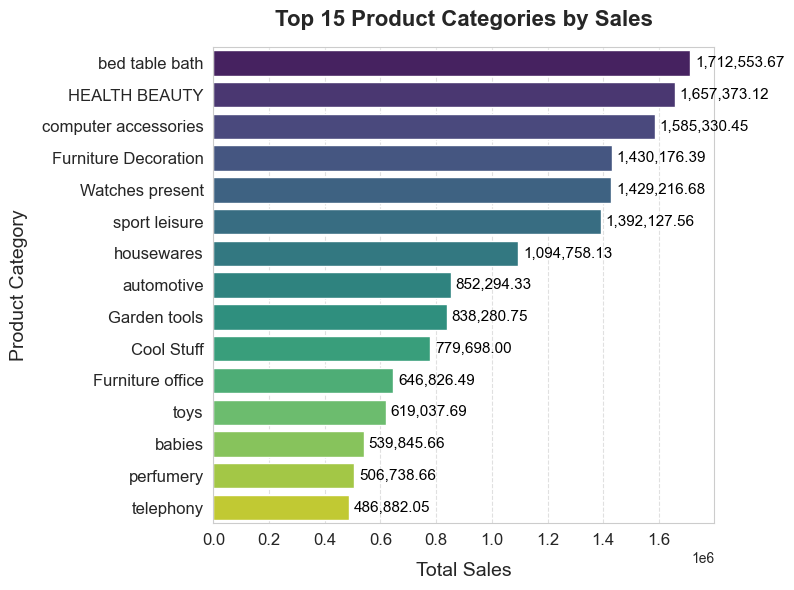

In [ ]:



df_sales = pd.DataFrame(df_sales, columns=['Category', 'Sales']).sort_values(by='Sales', ascending=False).head(15)

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

ax = sns.barplot(x='Sales', y='Category', data=df_sales, palette='viridis')

for index, value in enumerate(df_sales['Sales']):
    ax.text(value + 0.01 * df_sales['Sales'].max(), index, f"{value:,.2f}", va='center', fontsize=11, color='black')

plt.xlabel('Total Sales', fontsize=14, labelpad=10)
plt.ylabel('Product Category', fontsize=14, labelpad=10)
plt.title('Top 15 Product Categories by Sales', fontsize=16, fontweight='bold', pad=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()


# 4. Calculate the percentage of orders that were paid in installments.


In [ ]:
percentage_installments = (dataframes['payments']['payment_installments'] >= 1).sum() / len(dataframes['payments']) * 100

print("The percentage of orders that were paid in installments is", round(percentage_installments, 4))


The percentage of orders that were paid in installments is 99.9981


# 5. Count the number of customers from each state.


/var/folders/nw/bzm5v5js71dcfp1ywhh2mgp40000gn/T/ipykernel_48923/1323736971.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='State', y='Customer Count', data=df_state_counts, palette='coolwarm')


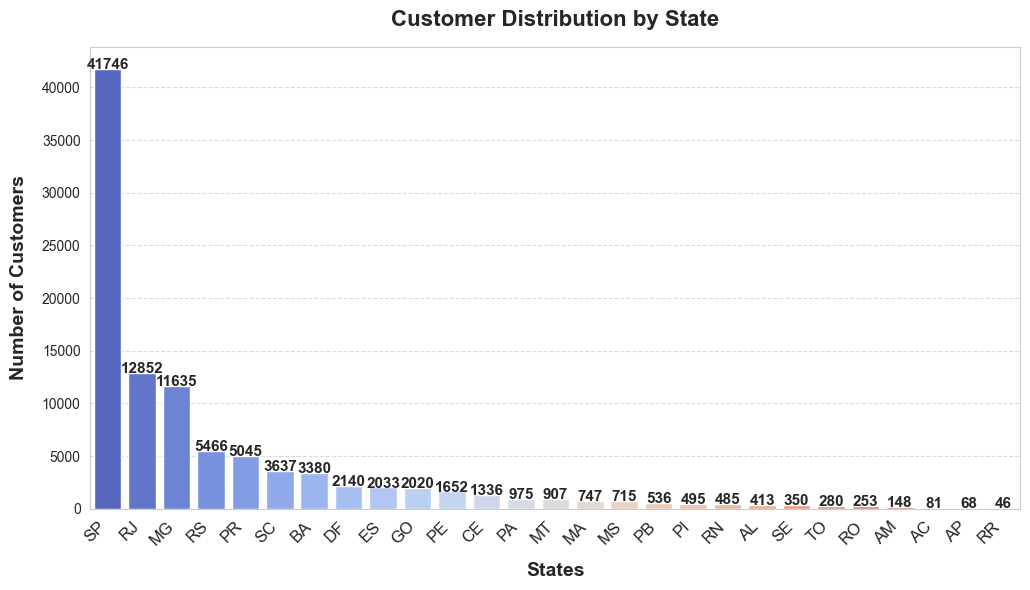

In [ ]:
df_customers = dataframes['customers']

df_state_counts = df_customers.groupby('customer_state', as_index=False)['customer_id'].count()
df_state_counts.columns = ['State', 'Customer Count']
df_state_counts = df_state_counts.sort_values(by='Customer Count', ascending=False)

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

ax = sns.barplot(x='State', y='Customer Count', data=df_state_counts, palette='coolwarm')

for index, value in enumerate(df_state_counts['Customer Count']):
    ax.text(index, value + 2, str(value), ha='center', fontsize=11, fontweight='bold')

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.xlabel("States", fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel("Number of Customers", fontsize=14, fontweight='bold', labelpad=10)
plt.title("Customer Distribution by State", fontsize=16, fontweight='bold', pad=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# 1. Calculate the number of orders per month in 2018.

Intermediate problems


/var/folders/nw/bzm5v5js71dcfp1ywhh2mgp40000gn/T/ipykernel_48923/3390912264.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='months', y='order_counts', data=df_monthly_orders, order=month_order, palette='coolwarm')


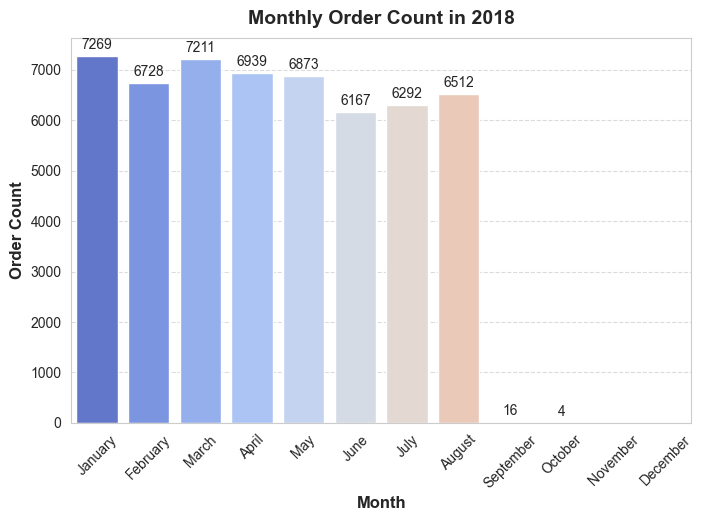

In [ ]:

df_orders = dataframes['orders']
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'], errors='coerce')

df_2018 = df_orders[df_orders['order_purchase_timestamp'].dt.year == 2018]
df_monthly_orders = df_2018.groupby(df_2018['order_purchase_timestamp'].dt.month_name())['order_id'].count().reset_index()
df_monthly_orders.columns = ['months', 'order_counts']

month_order = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]

df_monthly_orders['months'] = pd.Categorical(df_monthly_orders['months'], categories=month_order, ordered=True)
df_monthly_orders = df_monthly_orders.sort_values('months')

plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")

ax = sns.barplot(x='months', y='order_counts', data=df_monthly_orders, order=month_order, palette='coolwarm')

for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=10, label_type='edge', padding=3)

plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Month", fontsize=12, fontweight='bold')
plt.ylabel("Order Count", fontsize=12, fontweight='bold')
plt.title("Monthly Order Count in 2018", fontsize=14, fontweight='bold', pad=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


# 2. Find the average number of products per order, grouped by customer city.


/var/folders/nw/bzm5v5js71dcfp1ywhh2mgp40000gn/T/ipykernel_48923/1823182761.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


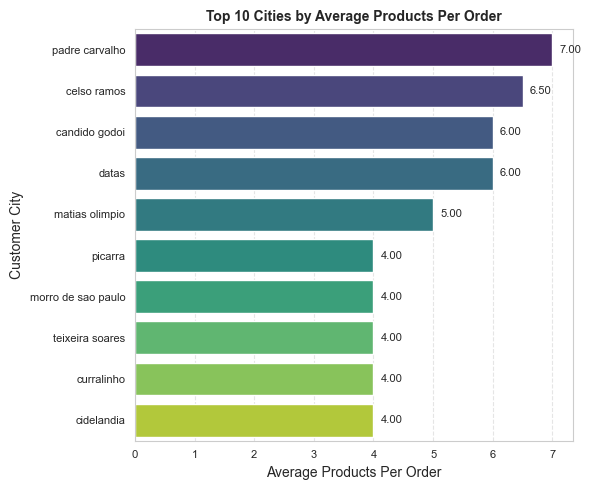

In [ ]:

order_items = dataframes['order_items']
orders = dataframes['orders']
customers = dataframes['customers']

count_per_order = orders.merge(order_items, on='order_id').groupby(['order_id', 'customer_id']).size().reset_index(name='oc')

df_avg_orders = customers.merge(count_per_order, on='customer_id').groupby('customer_city', as_index=False)['oc'].mean()
df_avg_orders.columns = ['Customer City', 'Average Products Per Order']
df_avg_orders['Average Products Per Order'] = df_avg_orders['Average Products Per Order'].round(2)

top_cities = df_avg_orders.sort_values(by='Average Products Per Order', ascending=False).head(10)

plt.figure(figsize=(6, 5))
sns.set_style("whitegrid")

ax = sns.barplot(
    x='Average Products Per Order',
    y='Customer City',
    data=top_cities,
    palette='viridis'
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=8, label_type='edge', padding=5)

plt.xlabel("Average Products Per Order", fontsize=10)
plt.ylabel("Customer City", fontsize=10)
plt.title("Top 10 Cities by Average Products Per Order", fontsize=10, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()

plt.show()


# 3. Calculate the percentage of total revenue contributed by each product category.


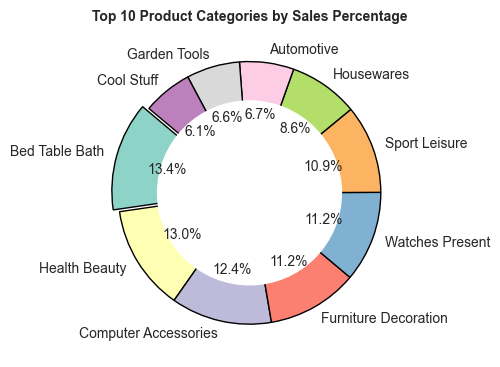

In [ ]:


products = dataframes['products']
order_items = dataframes['order_items']
payments = dataframes['payments']

merged_df = order_items.merge(products, on='product_id').merge(payments, on='order_id')

total_sales = merged_df['payment_value'].sum()
df_sales_percentage = merged_df.groupby('product_category', as_index=False)['payment_value'].sum()
df_sales_percentage['sales_percentage'] = round((df_sales_percentage['payment_value'] / total_sales) * 100, 2)
df_sales_percentage = df_sales_percentage[['product_category', 'sales_percentage']].sort_values(by='sales_percentage', ascending=False)

df_sales_percentage['product_category'] = df_sales_percentage['product_category'].str.title()

top_categories = df_sales_percentage.head(10)

plt.figure(figsize=(5, 5))
colors = sns.color_palette("Set3", len(top_categories))
explode = [0.05] + [0] * (len(top_categories) - 1)

plt.pie(
    top_categories['sales_percentage'],
    labels=top_categories['product_category'],
    autopct='%1.1f%%',
    colors=colors,
    startangle=140,
    wedgeprops={'edgecolor': 'black'},
    explode=explode
)

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)

plt.title("Top 10 Product Categories by Sales Percentage", fontsize=10, fontweight='bold')
plt.tight_layout()

plt.show()


# 4. Identify the correlation between product price and the number of times a product has been purchased.


In [ ]:

import numpy as np

products = dataframes['products']
order_items = dataframes['order_items']

df = order_items.merge(products, on='product_id').groupby('product_category', as_index=False).agg(
    order_count=('product_id', 'count'),
    price=('price', 'mean')
)

df['price'] = df['price'].round(2)

correlation = np.corrcoef(df['order_count'], df['price'])[0, 1]

print('The correlation between product price and the number of times a product has been purchased:', round(correlation, 4))


The correlation between product price and the number of times a product has been purchased: -0.1063


# 5. Calculate the total revenue generated by each seller, and rank them by revenue.


/var/folders/nw/bzm5v5js71dcfp1ywhh2mgp40000gn/T/ipykernel_48923/990027875.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='index', y='revenue', data=df_revenue, palette="Blues_r")


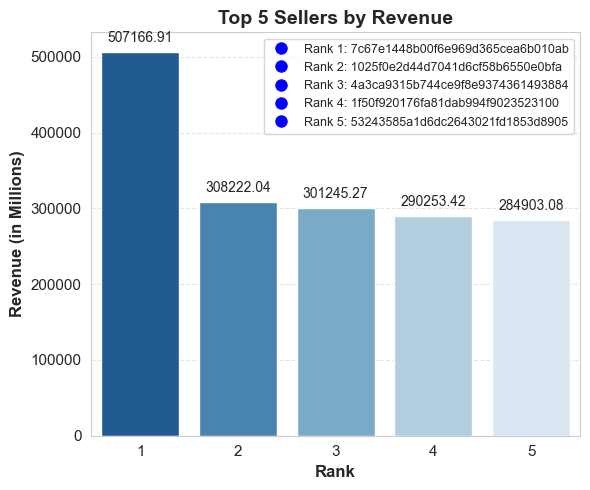

In [ ]:


order_items = dataframes['order_items']
payments = dataframes['payments']
sellers = dataframes['sellers']

df_revenue = order_items.merge(payments, on='order_id').merge(sellers, on='seller_id')

df_revenue = df_revenue.groupby('seller_id', as_index=False)['payment_value'].sum()
df_revenue.columns = ['seller_id', 'revenue']

df_revenue = df_revenue.sort_values(by='revenue', ascending=False).head(5)

df_revenue['index'] = range(1, len(df_revenue) + 1)

seller_id_mapping = df_revenue.set_index('index')['seller_id'].to_dict()

plt.figure(figsize=(6, 5))
sns.set_style("whitegrid")

ax = sns.barplot(x='index', y='revenue', data=df_revenue, palette="Blues_r")

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=10, padding=5)

plt.xlabel("Rank", fontsize=12, fontweight='bold')
plt.ylabel("Revenue (in Millions)", fontsize=12, fontweight='bold')
plt.title("Top 5 Sellers by Revenue", fontsize=14, fontweight='bold')

plt.xticks(ticks=df_revenue['index'] - 1, labels=df_revenue['index'], fontsize=11)
legend_labels = [f"Rank {index}: {seller_id}" for index, seller_id in seller_id_mapping.items()]
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor='b')
                    for label in legend_labels], loc='upper right', fontsize=9)

plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


# 1. Calculate the moving average of order values for each customer over their order history.

Advanced problems

In [ ]:
import pandas as pd

orders = dataframes['orders']
payments = dataframes['payments']

df_orders = orders.merge(payments, on='order_id')[['customer_id', 'order_purchase_timestamp', 'payment_value']]
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'], errors='coerce')

df_orders = df_orders.sort_values(by=['customer_id', 'order_purchase_timestamp'])
df_orders['moving_avg'] = df_orders.groupby('customer_id')['payment_value'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)

df_orders.columns = ['customer_id', 'order_purchase_timestamp', 'payment', 'moving_avg']
df_orders


,customer_id,order_purchase_timestamp,payment,moving_avg
71587,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
10466,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
68795,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
45159,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35
6119,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01
...,...,...,...,...
15766,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.12
98782,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.13
45235,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.13
77168,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.50


# 2. Calculate the cumulative sales per month for each year.


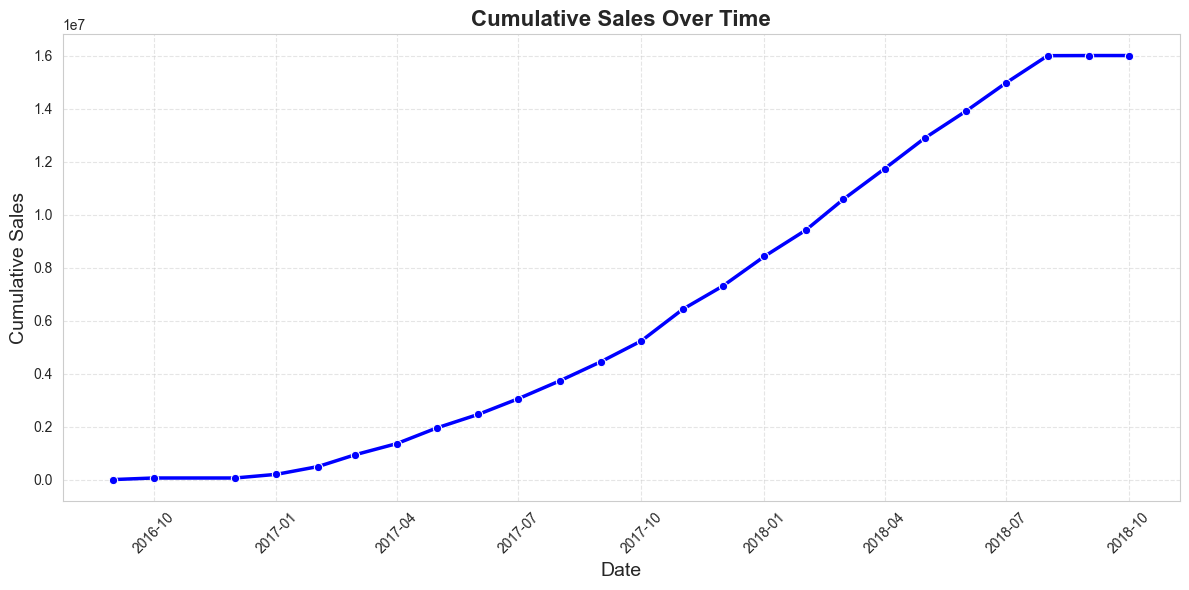

In [ ]:

orders = dataframes['orders'][['order_id', 'order_purchase_timestamp']].copy()
payments = dataframes['payments'][['order_id', 'payment_value']].copy()

orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], errors='coerce')

df_sales = orders.merge(payments, on='order_id', how='inner')

df_sales = df_sales.loc[:, ~df_sales.columns.duplicated()]

df_sales['Year'] = df_sales['order_purchase_timestamp'].dt.year
df_sales['Month'] = df_sales['order_purchase_timestamp'].dt.month

df_monthly_sales = df_sales.groupby(['Year', 'Month'], as_index=False)['payment_value'].sum()

df_monthly_sales = df_monthly_sales.rename(columns={'payment_value': 'Monthly Sales'})

df_monthly_sales['Cumulative Sales'] = df_monthly_sales['Monthly Sales'].cumsum()

df_monthly_sales['Date'] = pd.to_datetime(df_monthly_sales['Year'].astype(str) + '-' + df_monthly_sales['Month'].astype(str), format='%Y-%m')

plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Cumulative Sales', data=df_monthly_sales, marker='o', linewidth=2.5, color='b')

plt.xlabel("Date", fontsize=14)
plt.ylabel("Cumulative Sales", fontsize=14)
plt.title("Cumulative Sales Over Time", fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


# 3. Calculate the year-over-year growth rate of total sales.


In [ ]:

orders = dataframes['orders'][['order_id', 'order_purchase_timestamp']].copy()
payments = dataframes['payments'][['order_id', 'payment_value']].copy()

orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], errors='coerce')

df_sales = orders.merge(payments, on='order_id', how='inner')

df_sales['Year'] = df_sales['order_purchase_timestamp'].dt.year

df_yearly_sales = df_sales.groupby('Year', as_index=False)['payment_value'].sum()

df_yearly_sales = df_yearly_sales.rename(columns={'payment_value': 'Total Sales'})

df_yearly_sales['YoY % Growth'] = ((df_yearly_sales['Total Sales'] - df_yearly_sales['Total Sales'].shift(1)) /
                                    df_yearly_sales['Total Sales'].shift(1)) * 100

df_yearly_sales


,Year,Total Sales,YoY % Growth
0,2016,59362.34,NaN
1,2017,7249746.73,12112.703761
2,2018,8699763.05,20.000924


# 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.


In [ ]:

customers = dataframes['customers'][['customer_id']].copy()
orders = dataframes['orders'][['customer_id', 'order_purchase_timestamp']].copy()

orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], errors='coerce')

first_orders = orders.groupby('customer_id')['order_purchase_timestamp'].min().reset_index()
first_orders = first_orders.rename(columns={'order_purchase_timestamp': 'first_order'})

df_repeat_orders = orders.merge(first_orders, on='customer_id', how='inner')

df_repeat_orders = df_repeat_orders[
    (df_repeat_orders['order_purchase_timestamp'] > df_repeat_orders['first_order']) &
    (df_repeat_orders['order_purchase_timestamp'] < df_repeat_orders['first_order'] + pd.DateOffset(months=6))
]

repeat_customers = df_repeat_orders['customer_id'].nunique()
total_customers = first_orders['customer_id'].nunique()

repeat_purchase_rate = (repeat_customers / total_customers) * 100 if total_customers > 0 else 0.0

# Display result
df = pd.DataFrame({'Repeat Purchase Rate': [repeat_purchase_rate]})
df

"since the repeat purchase rate is 0.0, it means that no customer has made a repeat purchase within 6 months of their first purchase "



'since the repeat purchase rate is 0.0, it means that no customer has made a repeat purchase within 6 months of their first purchase '

# 5. Identify the top 3 customers who spent the most money in each year.

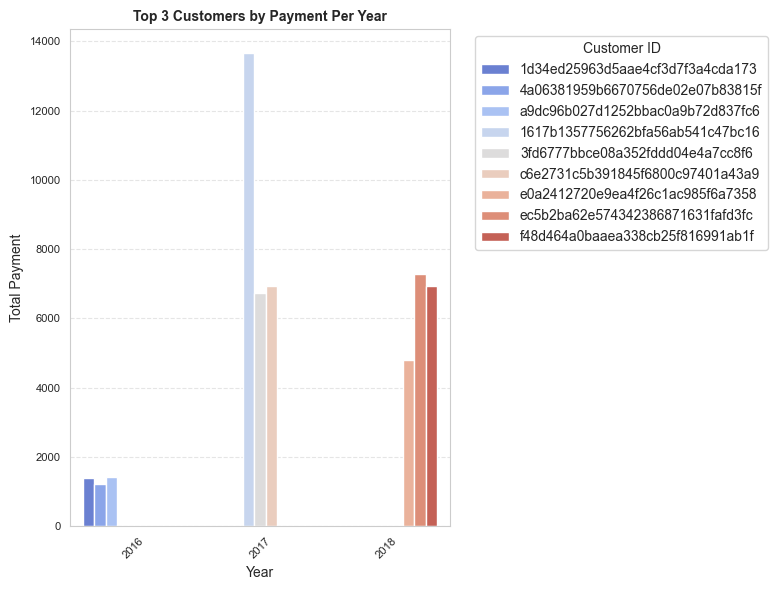

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

orders = dataframes['orders'][['order_id', 'customer_id', 'order_purchase_timestamp']].copy()
payments = dataframes['payments'][['order_id', 'payment_value']].copy()

orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], errors='coerce')

df_sales = orders.merge(payments, on='order_id', how='inner')

df_sales['Year'] = df_sales['order_purchase_timestamp'].dt.year

df_customer_sales = df_sales.groupby(['Year', 'customer_id'], as_index=False)['payment_value'].sum()

df_customer_sales = df_customer_sales.rename(columns={'payment_value': 'Total Payment'})

df_customer_sales['Rank'] = df_customer_sales.groupby('Year')['Total Payment'].rank(method='dense', ascending=False)

df_top_customers = df_customer_sales[df_customer_sales['Rank'] <= 3]

plt.figure(figsize=(8, 6))
sns.barplot(x='Year', y='Total Payment', hue='customer_id', data=df_top_customers, palette="coolwarm")

plt.xlabel("Year", fontsize=10)
plt.ylabel("Total Payment", fontsize=10)
plt.title("Top 3 Customers by Payment Per Year", fontsize=10, fontweight='bold')
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.legend(title="Customer ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()



## 🔹 Conclusion

The analysis of the sales data provides key insights into customer behavior, product performance, and payment trends. In **2017, a total of 45,101 orders** were placed, demonstrating strong demand. The **top-selling product categories** were **Bed, Table & Bath, Furniture & Decoration, and Automotive**, contributing significantly to revenue.  

An overwhelming **99.9981% of orders were paid in installments**, indicating that most customers prefer installment plans over full payments. The **customer base spans 41,746 unique customers**, with the highest concentration from a specific state. However, a major concern is the **0% repeat purchase rate within 6 months**, suggesting that customers do not return for additional purchases within a short timeframe.  

Another key finding is the **negative correlation (-0.1063) between product price and the number of purchases**, indicating that higher-priced products are slightly less frequently purchased. Additionally, the **year-over-year (YoY) growth from 2016 to 2017 was exceptionally high (12,112.7%)**, but this growth stabilized to **20.0% in 2018**.  





## 🔹 Recommendations  


To **increase revenue and encourage repeat purchases**, it is essential to introduce **loyalty programs**, **personalized follow-up emails**, and **subscription models** for frequently bought products. Since **99.99% of orders are paid via installments**, extending **longer EMI tenure, partnering with banks for low-interest plans**, and promoting **interest-free installment options** will enhance conversions. Additionally, **seasonal discounts, product bundling, and limited-time offers** can help optimize pricing strategies and improve sales of high-value products.  

Expanding **high-performing categories such as Bed, Table & Bath and Furniture & Decoration** will boost revenue, while **introducing premium versions and bundle deals** can further increase order value. Since a **specific state contributes the highest number of customers**, leveraging **localized marketing, regional promotions, and vernacular language advertisements** will maximize conversions. The **12,112.7% YoY growth in 2017** must be investigated to identify its key drivers, such as **seasonality, marketing efforts, or product launches**, to replicate successful strategies for sustained long-term growth.  

To **improve customer engagement and retention**, implementing **retargeting ads, abandoned cart reminders, and personalized product recommendations** is crucial. Additionally, launching an **exclusive VIP membership program** with **early access to sales, special discounts, and exclusive perks** can encourage long-term customer loyalty. Conducting a **Customer Lifetime Value (LTV) analysis** and developing a **forecasting model for future sales trends** will help refine targeted marketing campaigns and ensure strategic business growth.  


